# Pretrained neural network Xception with dense512 as a classifier layer

In [ ]:
# GPU info
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install -q gputil
!pip install -q psutil
!pip install -q humanize
import psutil as ps # library for retrieving information on running processes and system utilization
import humanize as hm # library for turning a number into a fuzzy human-readable
import os # library for operations with operation system 
import GPUtil as GPU # access to GPU subsystem
GPUs = GPU.getGPUs() # get number of GPUs
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
process = ps.Process(os.getpid())
print(f'Gen RAM Free: {hm.naturalsize( ps.virtual_memory().available )} | Proc size: {hm.naturalsize( process.memory_info().rss )}')
print( 'GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util: {2:3.0f}% | Total: {3:.0f}MB'.format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
print(f'GPU Model: {gpu.name}')

Gen RAM Free: 26.1 GB | Proc size: 94.9 MB
GPU RAM Free: 15109MB | Used: 0MB | Util:   0% | Total: 15109MB
GPU Model: Tesla T4


In [ ]:
# Keras's libraries
from tensorflow.keras.applications import Xception # Pretrained models
from tensorflow.keras.applications.xception import preprocess_input # for preprocessing image for the model
from tensorflow.keras.models import Model, Sequential, load_model # models
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization # Layers
from tensorflow.compat.v1.keras.preprocessing.image import ImageDataGenerator # Load and augmentation
from tensorflow.keras.optimizers import Adam, Adadelta, SGD # Optimizers
from tensorflow.keras import utils # Utils for converting to One Hot-Encoding
from tensorflow.keras.utils import plot_model # Draw model
from tensorflow.keras.preprocessing import image # Load images
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau # Callbacks

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Metrics

import numpy as np # Working with arrays
import matplotlib.pyplot as plt # For charts
# from PIL import Image # Load images
import random # Random library
import math # Math functions
import os # File system utils
import gdown # Load files from web

# Draw charts in the same windows
%matplotlib inline



In [ ]:
# Colab filesystem
from google.colab import files 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unpack files
# !unzip -q -o '/content/drive/MyDrive/archive.zip' -d /content
!unzip -q -o '/content/drive/MyDrive/classification.zip' -d /content

In [ ]:
# Look at the dirs
!ls /content/train
!ls /content/test

bag  bal  ban  bea  can  env  gbt  mon	pbt  toy
bag  bal  ban  bea  can  env  gbt  mon	pbt  toy


In [ ]:
# Hyperparameters
TRAIN_PATH  = '/content/train'  # Our source files
TEST_PATH   = '/content/test'   # Here we will drop test set

TEST_SPLIT  = 0.2 # 20% for test data
VAL_SPLIT   = 0.2 # 20% for validation data 

IMG_WIDTH   = 224 # Image width for neural network
IMG_HEIGHT  = 224 # Image height for neural network

BATCH_SIZE    = 256                        # Batch size for training
OPTIMIZER     = Adam(learning_rate=1e-6)  # Optimizer
EPOCHS        = 100                       # Epochs

# Augmentation parameters
ROTATION_RANGE      = 8     # Degree range for random rotations
WIDTH_SHIFT_RANGE   = 0.2   # Horizontal shift limit up to %
HEIGHT_SHIFT_RANGE  = 0.2   # Vertical shift limit up to %
ZOOM_RANGE          = 0.15  # [1-zoom_range, 1+zoom_range]
BRIGHTNESS_RANGE    = (0.7, 1.3)  #  Range for picking a brightness shift value from
HORIZONTAL_FLIP     = True  # Randomly flip inputs horizontally

In [ ]:
# A list of class names
CLASS_LIST = sorted(os.listdir(TRAIN_PATH)) # Assign number for each class by sorting the set of classes

# Number of classes
CLASS_COUNT = len(CLASS_LIST)

print(f'Labels: {CLASS_LIST}\nNumber of classes: {CLASS_COUNT}')

Labels: ['bag', 'bal', 'ban', 'bea', 'can', 'env', 'gbt', 'mon', 'pbt', 'toy']
Number of classes: 10


In [ ]:
# # Dividing the complete dataset into training and test sets
# os.mkdir(TEST_PATH) # Folder for test data
# total_count = 0
# test_count = 0

# for class_name in CLASS_LIST:
#   class_path  = f'{TRAIN_PATH}/{class_name}'  # Full train dir path of the current class
#   test_path   = f'{TEST_PATH}/{class_name}'   # Full test dir path for the current class
#   class_files = os.listdir(class_path)        # A list of train images in the current class
#   class_file_count = len(class_files)         # Total number of images in the current class folder
#   os.mkdir(test_path)                         # Make a folder for the current test class images
#   test_file_count = int(class_file_count*TEST_SPLIT) # The number of test data images from the current class
#   random.shuffle(class_files)                 # Shuffle list of images in the current class
#   test_files = class_files[:test_file_count]  # A list of test images in the current class
#   for f in test_files:                        # Move test data images into new folder for test data for the current class
#     os.rename(f'{class_path}/{f}', f'{test_path}/{f}')
#   total_count += class_file_count             # Increase counter for total images
#   test_count += test_file_count               # Increase counter for test images
#   print(f'Class: {class_name}, Total:{class_file_count}, Test data: {test_file_count}')

# print(f'Total data: {total_count}, train data: {total_count-test_count}, test data: {test_count}')

In [ ]:
# Image Generators
train_datagen = ImageDataGenerator(
    # rescale=1. / 255,
    rotation_range=ROTATION_RANGE,
    width_shift_range=WIDTH_SHIFT_RANGE,
    height_shift_range=HEIGHT_SHIFT_RANGE,
    zoom_range=ZOOM_RANGE,
    brightness_range=BRIGHTNESS_RANGE,
    horizontal_flip=HORIZONTAL_FLIP,
    validation_split=VAL_SPLIT,
    preprocessing_function=preprocess_input, # preprocess image
    )

validation_datagen = ImageDataGenerator(
    # rescale=1. / 255,
    validation_split=VAL_SPLIT,
    preprocessing_function=preprocess_input, # preprocess image
    )

test_datagen = ImageDataGenerator(
    # rescale=1. / 255,
    preprocessing_function=preprocess_input, # preprocess image
    )

In [ ]:
# Data generator for training
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
    )

# Data generator for validation
validation_generator = validation_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
    )

# Data generator for testing
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
    )

Found 47874 images belonging to 10 classes.
Found 11964 images belonging to 10 classes.
Found 14954 images belonging to 10 classes.


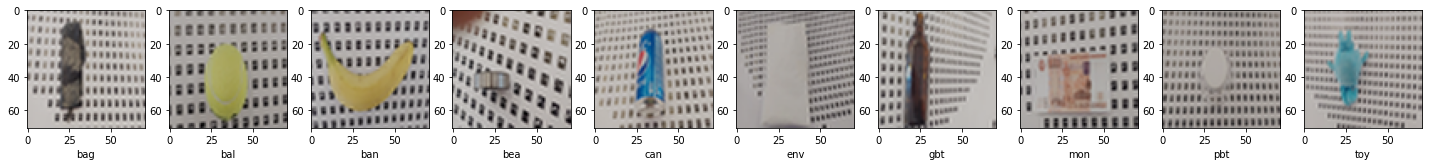

In [ ]:
# Look at the random images from each class
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(25, 5))                   
for i in range(CLASS_COUNT):  # For each class
  class_path = TRAIN_PATH + '/' + CLASS_LIST[i]                                            
  images_list = os.listdir(class_path)
  image_path = class_path + '/' + random.choice(images_list)
  axs[i].imshow(image.load_img(image_path, target_size=(71, 71)))
  axs[i].set_xlabel(CLASS_LIST[i])
plt.show()

In [ ]:
# Callbacks
checkpoint = [
             ModelCheckpoint('/content/drive/MyDrive/4_Xception_dense512.h5', 
             monitor='val_loss', 
             save_best_only=True)
             ]
early = EarlyStopping(monitor='val_loss', patience=5, mode='auto')
lr_reduce = ReduceLROnPlateau(
                           monitor='val_loss',
                           patience=5, # 4
                           verbose=0, 
                           mode='auto'
                           )

In [ ]:
# Function of training and evaluation
def train_model(model,
                train_data,
                val_data):
  
  # Model compilation
  model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])

  # Model train
  history = model.fit(train_data,
                      steps_per_epoch = train_data.samples // BATCH_SIZE,
                      validation_data=val_data,
                      validation_steps = val_data.samples // BATCH_SIZE,
                      epochs=EPOCHS,
                      # batch_size=BATCH_SIZE,
                      callbacks=[early,checkpoint,lr_reduce])

  # Visualization of the training process
  plt.plot(history.history['accuracy'], label='Part of the right answers on the training set')
  plt.plot(history.history['val_accuracy'], label='Part of the right answers on the validation set')
  plt.xlabel('Epoch of the training')
  plt.ylabel('Part of the right answers')
  plt.legend()
  plt.show()

# Function for evaluating model
def eval_model(model,
               x,
               y,
               class_labels=CLASS_LIST, 
               title='classification'):
  
  # Model compilation
  model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])

  # Model prediction
  y_pred = model.predict(x) # x_test
  y_true = y                # y_test

  # Confusion matrix
  cm = confusion_matrix(np.argmax(y_true, axis=1),
                        np.argmax(y_pred, axis=1),
                        normalize='true')
  cm = np.around(cm, 2)

  # Graph of confusion matrix
  fig, ax = plt.subplots(figsize=(10,10))
  ax.set_title(f'Neural network {title}: normilized confusion matrix', fontsize=18)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
  disp.plot(ax=ax)
  ax.images[-1].colorbar.remove()      
  fig.autofmt_xdate(rotation=90)        
  plt.xlabel('Predicted classes', fontsize=16)
  plt.ylabel('Actual classes', fontsize=16)
  plt.show()    

  print('-'*100)
  print(f'Neural network: {title}')

  # For each class:
  for cls in range(len(class_labels)):
      # The index of the class with the maximum prediction (confidence) value 
      cls_pred = np.argmax(cm[cls])
      # A message about the correctness or incorrectness of the prediction
      msg = 'Correct' if cls_pred == cls else 'Incorrect'
      # Text message about predicted class
      print('Class: {:<20} {:3.0f}% neural network predicted as a class {:<20} - {}'.format(class_labels[cls],
                                                                              100. * cm[cls, cls_pred],
                                                                              class_labels[cls_pred],
                                                                              msg))

  # The average recognition accuracy ( the average of the diagonal elements of the error matrix)
  print('\nThe average recognition accuracy: {:3.0f}%'.format(100. * cm.diagonal().mean()))

In [ ]:
# Loading the pretrained model
Xception_net = Xception(weights='imagenet',
                        include_top=False, 
                        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
print(f'\nLoading the model is complete.\nNumber of layers: {len(Xception_net.layers)}')

83697664/83683744 [==============================] - 2s 0us/step

Loading the model is complete.
Number of layers: 132


Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

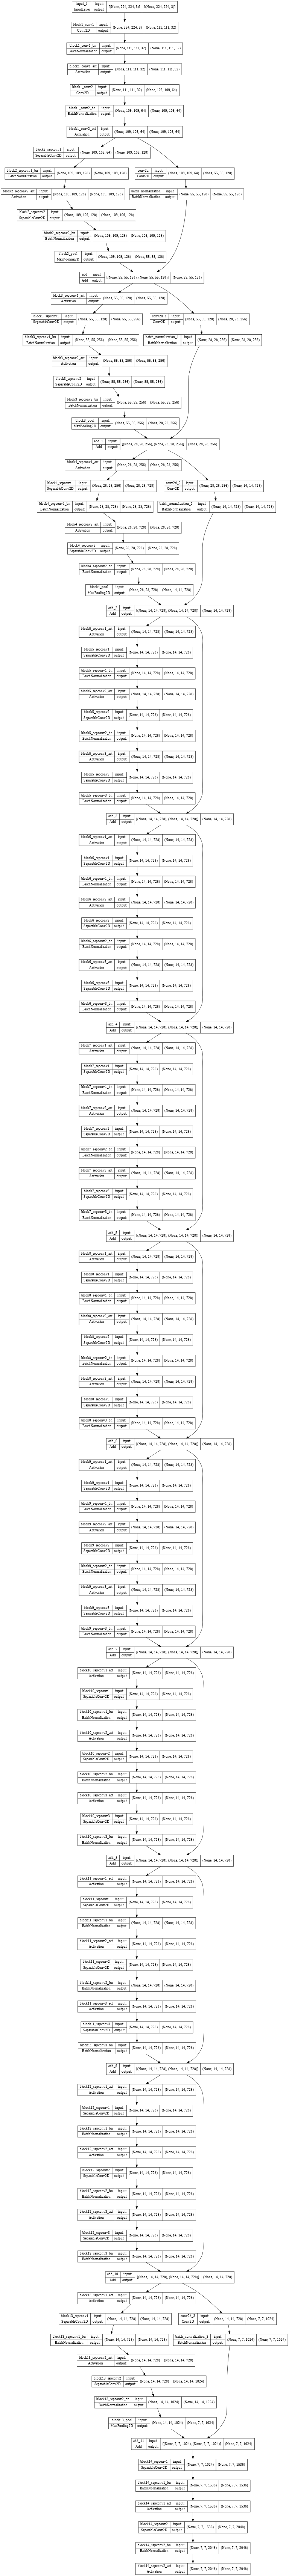

In [ ]:
# Freezing the weights of the pretrained neural network
Xception_net.trainable = False

Xception_net.summary()

print()

plot_model(Xception_net, dpi=48, show_shapes=True)

In [ ]:
# Creating a composite neural network

# img_input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
# flatten_layer = Flatten()(Xception_net.layers[-2].output) # Xception_net without last Dense layer connects to Flatten()
# hidden_layer = Dense(512, activation='relu')(flatten_layer) # classifier hidden layer
# out_layer = Dense(CLASS_COUNT, activation='softmax')(hidden_layer) # classifier output layer
# model = Model(inputs=Xception_net.input, outputs=out_layer) # main model

model = Sequential()
model.add(Xception_net)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.1))  
model.add(Dense(CLASS_COUNT, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 512)               51380736  
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 72,247,346
Trainable params: 51,385,866
Non-trainable params: 20,861,480
_________________________________________________________________


Epoch 1/100
187/187 [==============================] - 694s 4s/step - loss: 0.7758 - accuracy: 0.8098 - val_loss: 0.4491 - val_accuracy: 0.8307 - lr: 1.0000e-06
Epoch 2/100
187/187 [==============================] - 693s 4s/step - loss: 0.1569 - accuracy: 0.9798 - val_loss: 0.3156 - val_accuracy: 0.8737 - lr: 1.0000e-06
Epoch 3/100
187/187 [==============================] - 686s 4s/step - loss: 0.0771 - accuracy: 0.9915 - val_loss: 0.2591 - val_accuracy: 0.8947 - lr: 1.0000e-06
Epoch 4/100
187/187 [==============================] - 687s 4s/step - loss: 0.0500 - accuracy: 0.9950 - val_loss: 0.2419 - val_accuracy: 0.9060 - lr: 1.0000e-06
Epoch 5/100
187/187 [==============================] - 688s 4s/step - loss: 0.0363 - accuracy: 0.9963 - val_loss: 0.2181 - val_accuracy: 0.9103 - lr: 1.0000e-06
Epoch 6/100
187/187 [==============================] - 690s 4s/step - loss: 0.0282 - accuracy: 0.9974 - val_loss: 0.2031 - val_accuracy: 0.9193 - lr: 1.0000e-06
Epoch 7/100
187/187 [=============

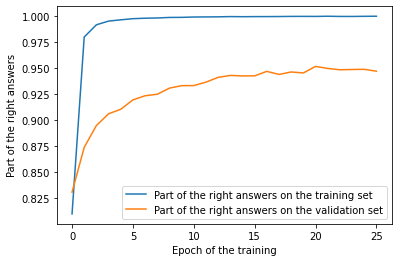

In [ ]:
# processing errors with truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Hyperparameters
BATCH_SIZE    = 256                        # Batch size for training
OPTIMIZER     = Adam(learning_rate=1e-6)  # Optimizer
EPOCHS        = 100                       # Epochs

# Training of the model
train_model(model, 
            train_generator, 
            validation_generator)

In [ ]:
# garbage collection
import gc    
gc.collect()

9000

In [ ]:
# Load last weights
model.load_weights('/content/drive/MyDrive/4_Xception_dense512.h5')
# model = load_model('/content/drive/MyDrive/4_Xception_dense512.h5', compile = True)

In [ ]:
# # Aditional traning

# # processing errors with truncated images
# from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True

# # Hyperparameters
# BATCH_SIZE    = 256                        # Batch size for training
# OPTIMIZER     = Adam(learning_rate=1e-6)  # Optimizer
# EPOCHS        = 100                       # Epochs

# # Training of the model
# train_model(model, 
#             train_generator, 
#             validation_generator)

In [ ]:
# Fine tuning
Xception_net.trainable = True
trainable = False
for layer in Xception_net.layers:
    if layer.name == 'conv2d_3': # the layer where features with dimensions 7x7 are starting
        trainable = True
    layer.trainable = trainable

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 512)               51380736  
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 72,247,346
Trainable params: 51,385,866
Non-trainable params: 20,861,480
_________________________________________________________________


Epoch 1/100
187/187 [==============================] - 680s 4s/step - loss: 0.0040 - accuracy: 0.9997 - val_loss: 0.1193 - val_accuracy: 0.9568 - lr: 1.0000e-06
Epoch 2/100
187/187 [==============================] - 668s 4s/step - loss: 0.0036 - accuracy: 0.9997 - val_loss: 0.1257 - val_accuracy: 0.9572 - lr: 1.0000e-06
Epoch 3/100
187/187 [==============================] - 664s 4s/step - loss: 0.0029 - accuracy: 0.9997 - val_loss: 0.1235 - val_accuracy: 0.9565 - lr: 1.0000e-06
Epoch 4/100
187/187 [==============================] - 665s 4s/step - loss: 0.0026 - accuracy: 0.9998 - val_loss: 0.1231 - val_accuracy: 0.9591 - lr: 1.0000e-06
Epoch 5/100
187/187 [==============================] - 669s 4s/step - loss: 0.0026 - accuracy: 0.9997 - val_loss: 0.1320 - val_accuracy: 0.9520 - lr: 1.0000e-06
Epoch 6/100
187/187 [==============================] - 667s 4s/step - loss: 0.0023 - accuracy: 0.9998 - val_loss: 0.1201 - val_accuracy: 0.9574 - lr: 1.0000e-06


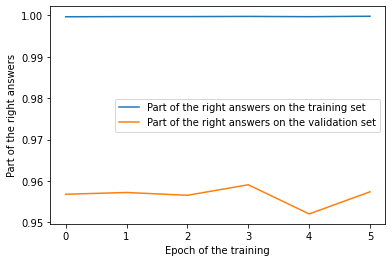

In [ ]:
# processing errors with truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Hyperparameters
BATCH_SIZE    = 256                        # Batch size for training
OPTIMIZER     = Adam(learning_rate=1e-6)  # Optimizer
EPOCHS        = 100                       # Epochs

# Training of the model
train_model(model, 
            train_generator, 
            validation_generator)

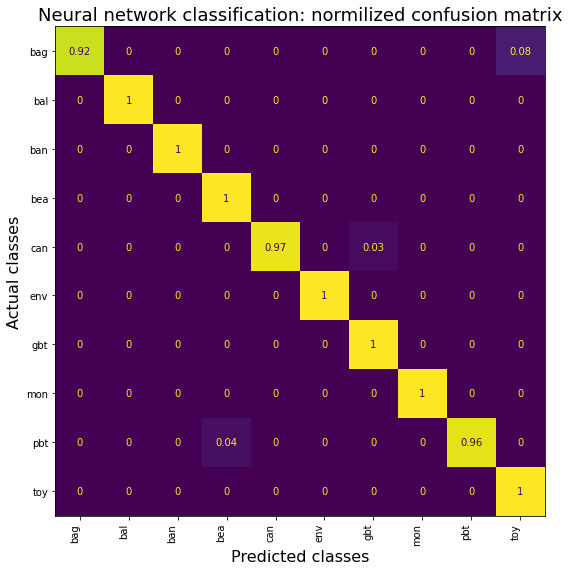

----------------------------------------------------------------------------------------------------
Neural network: classification
Class: bag                   92% neural network predicted as a class bag                  - Correct
Class: bal                  100% neural network predicted as a class bal                  - Correct
Class: ban                  100% neural network predicted as a class ban                  - Correct
Class: bea                  100% neural network predicted as a class bea                  - Correct
Class: can                   97% neural network predicted as a class can                  - Correct
Class: env                  100% neural network predicted as a class env                  - Correct
Class: gbt                  100% neural network predicted as a class gbt                  - Correct
Class: mon                  100% neural network predicted as a class mon                  - Correct
Class: pbt                   96% neural network predicted as a class

In [ ]:
# Evaluating of the model
eval_model(model,
           test_generator[0][0], 
           test_generator[0][1])

In [ ]:
# classes in test_generator
list(test_generator.class_indices)

['bag', 'bal', 'ban', 'bea', 'can', 'env', 'gbt', 'mon', 'pbt', 'toy']

In [ ]:
# garbage collection
import gc    
gc.collect()

11163

In [ ]:
# Load test data from directories
from PIL import ImageFile # Load images
ImageFile.LOAD_TRUNCATED_IMAGES = True # Load truncated images

x_test = [] # here we will put x for test data
y_test = [] # he we will put labels for test data

MAX_FILES_COUNT = 1000 # Limits the number of files in test data to save memory 

CLASS_LIST = list(test_generator.class_indices) # get class label from generator
CLASS_COUNT = len(CLASS_LIST) # count of classes from generator
for class_id, class_name in enumerate(CLASS_LIST):  # For each class
  class_path = TEST_PATH + '/' + class_name # path to current class
  file_list = os.listdir(class_path)
  random.shuffle(file_list) # Shuffle list of files in the current class
  for file_name in file_list[:MAX_FILES_COUNT]: # for each filename in class directory
    image_path = class_path + '/' + file_name # path to current image
    img = image.load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT)) # current image
    x = image.img_to_array(img) # the image as an array
    y = utils.to_categorical(class_id, CLASS_COUNT) # current label to One Hot Encoding
    x_test.append(x) # append x
    y_test.append(y) # append y

x_test = np.array(x_test) # convert to numpy array
x_test = preprocess_input(x_test) # preprocess images
y_test = np.array(y_test) # convert to numpy array

print(x_test.shape)
print(y_test.shape)

(8515, 224, 224, 3)
(8515, 10)


In [ ]:
# Evaluating with the origin test files
model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy']) # compile the model
scores = model.evaluate(x_test, y_test, verbose=0) # evaluating the model
print('\nPercent of the right answers on the test data: {:.2%}\n'\
      .format(scores[1]))


Percent of the right answers on the test data: 99.05%



In [ ]:
# # Final accuracy for test data
# # scores[0] - loss
# # scores[1] - percents of correct answers

# # Model compilation
# model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])
# scores = model.evaluate(test_generator[0][0], test_generator[0][1], verbose=0)  
# print('\nPercent of the right answers on the test data: {:.2%}\n'\
#       .format(scores[1]))

In [ ]:
# garbage collection
import gc    
gc.collect()

876

In [ ]:
# Evaluating currency of prediction test data for each class
total_currency = 0 # total currency for all classes
CLASS_LIST = list(train_generator.class_indices) # list of classes from generator
CLASS_COUNT = len(CLASS_LIST) # quantity of classes
y_train_labels = np.argmax(y_test, axis=1) # get labels from y_test without One Hot Encoding
# print(CLASS_LIST)
# print(CLASS_COUNT)

for class_id, class_name in enumerate(CLASS_LIST):  # For each class
  cur_ids = np.where(y_train_labels==class_id)[0] # indexes of samples in y_test that belong to current class class_id 
  total_labels_count = cur_ids.shape[0] # quantity of labels belongs to current class
  pred_labels = np.argmax( model.predict(x_test[cur_ids]) , axis=1) # labels after predict with current class
  correct_labels_count = np.where(pred_labels==class_id)[0].shape[0] # quantity labels after predict that belongs to current class
  cur_currency = correct_labels_count/total_labels_count # part of right predicted labels from all labels for current class
  total_currency += cur_currency # adjust total currency for all classes
  print(f'Class {class_name} recognized at {round(cur_currency, 2)*100}% \t: {correct_labels_count} \tfrom {total_labels_count}')

print(f'Total currency is {round(total_currency/CLASS_COUNT*100, 2)}%')

Class bag recognized at 99.0% 	: 975 	from 987
Class bal recognized at 100.0% 	: 1000 	from 1000
Class ban recognized at 100.0% 	: 547 	from 547
Class bea recognized at 100.0% 	: 997 	from 1000
Class can recognized at 97.0% 	: 971 	from 1000
Class env recognized at 100.0% 	: 418 	from 418
Class gbt recognized at 100.0% 	: 563 	from 563
Class mon recognized at 100.0% 	: 1000 	from 1000
Class pbt recognized at 96.0% 	: 963 	from 1000
Class toy recognized at 100.0% 	: 1000 	from 1000
Total currency is 99.19%


In [ ]:
# Function for getting size of a model in memory
# import tensorflow as tf 
def get_model_memory_usage(batch_size, model):
    import numpy as np
    try:
        from keras import backend as K
    except:
        from tensorflow.keras import backend as K

    shapes_mem_count = 0
    internal_model_mem_count = 0
    for l in model.layers:
        layer_type = l.__class__.__name__
        if layer_type == 'Model':
            internal_model_mem_count += get_model_memory_usage(batch_size, l)
        single_layer_mem = 1
        out_shape = l.output_shape
        if type(out_shape) is list:
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in model.trainable_weights])
    non_trainable_count = np.sum([K.count_params(p) for p in model.non_trainable_weights])

    number_size = 4.0
    if K.floatx() == 'float16':
        number_size = 2.0
    if K.floatx() == 'float64':
        number_size = 8.0

    total_memory = number_size * (batch_size * shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3) + internal_model_mem_count
    return gbytes

In [ ]:
# Total amount memory ocuppied by the model
print(get_model_memory_usage(BATCH_SIZE, model), 'Gbytes')

0.461 Gbytes
